In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from nltk.stem.snowball import SnowballStemmer 
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import shap

tqdm.pandas()
%matplotlib inline

## Загрузка данных

In [2]:
df = pd.read_csv("train_dataset_train.csv", index_col='id')

In [3]:
df

,name,groups
id,,
2442477,БЗМЖ Молоко ультропаст.Вкуснотеево900гр.3.2%ПЭТ/б,3
1564599,"15.6"" Ноутбук Acer Nitro 5 (AN515-54-58LL)(FHD...",10
841848,ЖЕВ.РЕЗИНКА ОРБИТ НЕЖНАЯ МЯТА XX 46153708,10
960348,Агрикола Грунт универсальный 50 л (Техноэкспор...,10
398622,"1. Игристое вино ""Каспийская коллекция"" ЗГУ ""Д...",10
...,...,...
5324046,8714100917541 ШАМПУНЬ TRESEMME BEA,10
2971888,1/1 Ксилен 0.1% капли назальные 10мл фл.-кап. ...,10
4713243,СЫР колбасный ЯНТАРЬ 1 кг Воронеж,10


## Загрузка ключевых слов, использованных моделью на предыдущем запуске

In [4]:
key_words = pd.read_csv('important_keywords.csv').iloc[:, 0]

In [5]:
base_words = list(filter(lambda x: '_' not in x and len(x.split()) == 1, key_words))
base_bigrams = list(filter(lambda x: '_' not in x and len(x.split()) == 2, key_words))
base_trigrams = list(filter(lambda x: '_' not in x and len(x.split()) == 3, key_words))
print(len(base_words), len(base_bigrams), len(base_trigrams))

609 284 55


## Рассмотрим датасет поближе

In [6]:
df.head(3)

,name,groups
id,,
2442477,БЗМЖ Молоко ультропаст.Вкуснотеево900гр.3.2%ПЭТ/б,3
1564599,"15.6"" Ноутбук Acer Nitro 5 (AN515-54-58LL)(FHD...",10
841848,ЖЕВ.РЕЗИНКА ОРБИТ НЕЖНАЯ МЯТА XX 46153708,10


In [7]:
df.shape

(658064, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658064 entries, 2442477 to 494535
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    658064 non-null  object
 1   groups  658064 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.1+ MB


## Проведем стемминг названий

Также добавим пару новых столбцов:

`total_len` -- длина названий в символах

`sign_len` -- длина названий в символах после их преобразования стеммером

`sign_frac` -- доля символов, не являющихся ни окончаниями, ни знаками препинания

`count_` -- длина названий в словах

`avg_len` -- средняя длина слов в символах

In [9]:
stemmer = SnowballStemmer("russian") 

In [10]:
df['total_len'] = df['name'].fillna(' ').progress_apply(len)
df['name'] = df['name'].fillna('').progress_apply(lambda x: ' '.join(filter(lambda x: len(x) > 0, map(stemmer.stem, 
                                                                                    re.split(r'[ ,"\_\-.()0-9//%:\*]', 
                                                                                             x)))))
df['sign_len'] = df['name'].fillna('').progress_apply(len)
df['sign_frac'] = df['sign_len']/df['total_len']
df['count_'] = df['name'].fillna('').progress_apply(lambda x: len(x.split()))
df['avg_len'] = df['total_len']/df['count_']

  0%|          | 0/658064 [00:00<?, ?it/s]

  0%|          | 0/658064 [00:00<?, ?it/s]

  0%|          | 0/658064 [00:00<?, ?it/s]

  0%|          | 0/658064 [00:00<?, ?it/s]

In [11]:
df.head(3)

,name,groups,total_len,sign_len,sign_frac,count_,avg_len
id,,,,,,,
2442477,бзмж молок ультропаст вкуснотеев гр пэт б,3,49,41,0.836735,7,7.000000
1564599,ноутбук Acer Nitro AN LL FHD IPS i H SSD NV GT...,10,100,60,0.600000,15,6.666667
841848,жев резинк орб нежн мят XX,10,41,26,0.634146,6,6.833333


## Посмотрим как часто различные слова / биграммы / триграммы встречаются в названиях и выберем те из них, по которым будем строить признаки

При выборе слов в качестве признаков для обучения на разных итерациях использовались слова, <<отобранные>> catboost при предыдущем запуске + слова с частотой вхождения из 

1. $(300, +\inf)$
2. $(200, 300]$
3. $(150, 200]$
4. $(125, 150]$
5. $(100, 125]$
6. $(90, 100]$
7. $(80, 90]$
8. $(70, 80]$

Нумерация здесь соответствует порядковому номеру запуска.

In [12]:
def count_instances(x, word):
    return (' '+x.lower()+' ').count(' '+word+' ')

In [13]:
full = ' '.join(df['name'].dropna())
name_set = Counter(full.split())
name_words = list(set(base_words + [x for x in name_set if name_set[x] <= 80 and name_set[x] > 70]))
word_lengths = pd.Series({word: len(word) for word in name_words})

In [14]:
len(name_words)

1038

In [15]:
bigram_set = Counter([a+' '+b for a, b in zip(full.split()[:-1], full.split()[1:])])
bigram_words = list(set(base_bigrams + [x for x in bigram_set if bigram_set[x] <= 80 and bigram_set[x] > 70]))
bigram_lengths = pd.Series({word: len(word) for word in bigram_words})

In [16]:
len(bigram_words)

1091

In [17]:
trigram_set = Counter([a+' '+b+' '+c for a, b, c in zip(full.split()[:-2], full.split()[1:-1], full.split()[2:])])
trigram_words = list(set(base_trigrams + [x for x in trigram_set if trigram_set[x] <= 80 and trigram_set[x] > 70]))
trigram_lengths = pd.Series({word: len(word) for word in trigram_words})

In [18]:
len(trigram_words)

329

## Для выбранных ключевых слов / биграмм / триграмм найдём те названия, в которых они встречаются

Количество их вхождений в каждое название (чаще всего $0$ или $1$) -- наши признаки.

Для ключевых словосочетаний каждого типа (отдельно взятых слов, биграмм и триграмм) введём следующие дополнительные признаки:

`???_count` -- количество ключевых словосочетаний данного типа, входящих в название

`???_frac` -- доля словосочетаний данного типа в названии, являющихся ключевыми

`???_total_len` -- суммарная длина ключевых словосочетаний данного типа в названии

`???_avg_len` -- средняя длина ключевых словосочетаний данного типа в названии

Также введём несколько признаков, общих для всех типов:

`total_count` -- количество всех ключевых словосочетаний в названии

`max_count` -- количество максимальных по включению ключевых словосочетаний в названии

`sign_total_len` -- суммарная длина всех ключевых словосочетаний в названии

`sign_avg_len` -- средняя длина всех ключевых словосочетаний в названии

In [19]:
df = pd.concat([df] + [pd.DataFrame({word: df["name"].map(lambda x: count_instances(x, word))})
                      for word in tqdm(name_words)], axis=1)

  0%|          | 0/1038 [00:00<?, ?it/s]

In [20]:
df['word_count'] = df[[word for word in name_words]].sum(axis=1)
df['word_frac'] = df['word_count']/(df['count_'] +0.0001)
df['word_total_len'] = (df[[word for word in name_words]]*word_lengths).sum(axis=1)
df['word_avg_len'] = df['word_total_len']/(df['word_count'] +0.0001)

In [21]:
df.head(3)

,name,groups,total_len,sign_len,sign_frac,count_,avg_len,выпаден,повар,ндс,...,опт,сок,классическ,дарницк,ремеслен,зат,word_count,word_frac,word_total_len,word_avg_len
id,,,,,,,,,,,,,,,,,,,,,
2442477,бзмж молок ультропаст вкуснотеев гр пэт б,3,49,41,0.836735,7,7.000000,0,0,0,...,0,0,0,0,0,0,5,0.714276,15,2.999940
1564599,ноутбук Acer Nitro AN LL FHD IPS i H SSD NV GT...,10,100,60,0.600000,15,6.666667,0,0,0,...,0,0,0,0,0,0,2,0.133332,8,3.999800
841848,жев резинк орб нежн мят XX,10,41,26,0.634146,6,6.833333,0,0,0,...,0,0,0,0,0,0,3,0.499992,12,3.999867


In [22]:
df = pd.concat([df] + [pd.DataFrame({word: df["name"].map(lambda x: count_instances(x, word))})
                      for word in tqdm(bigram_words)], axis=1)

  0%|          | 0/1091 [00:00<?, ?it/s]

In [23]:
df['bigram_count'] = df[[word for word in bigram_words]].sum(axis=1)
df['bigram_frac'] = df['bigram_count']/(df['count_'] +0.0001)
df['bigram_total_len'] = (df[[word for word in bigram_words]]*bigram_lengths).sum(axis=1)
df['bigram_avg_len'] = df['bigram_total_len']/(df['bigram_count'] +0.0001)

In [24]:
df.head(3)

,name,groups,total_len,sign_len,sign_frac,count_,avg_len,выпаден,повар,ндс,...,колбасн варен,полост рта,яшкин г,р х,шт бл,биойогурт пит,bigram_count,bigram_frac,bigram_total_len,bigram_avg_len
id,,,,,,,,,,,,,,,,,,,,,
2442477,бзмж молок ультропаст вкуснотеев гр пэт б,3,49,41,0.836735,7,7.000000,0,0,0,...,0,0,0,0,0,0,1,0.142855,10,9.999
1564599,ноутбук Acer Nitro AN LL FHD IPS i H SSD NV GT...,10,100,60,0.600000,15,6.666667,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,0.000
841848,жев резинк орб нежн мят XX,10,41,26,0.634146,6,6.833333,0,0,0,...,0,0,0,0,0,0,1,0.166664,10,9.999


In [25]:
df = pd.concat([df] + [pd.DataFrame({word: df["name"].map(lambda x: count_instances(x, word))})
                      for word in tqdm(trigram_words)], axis=1)

  0%|          | 0/329 [00:00<?, ?it/s]

In [26]:
df['trigram_count'] = df[[word for word in trigram_words]].sum(axis=1)
df['trigram_frac'] = df['trigram_count']/(df['count_'] +0.0001)
df['trigram_total_len'] = (df[[word for word in trigram_words]]*trigram_lengths).sum(axis=1)
df['trigram_avg_len'] = df['trigram_total_len']/(df['trigram_count'] + +0.0001)

In [27]:
df.head(3)

,name,groups,total_len,sign_len,sign_frac,count_,avg_len,выпаден,повар,ндс,...,хлеб в с,нарезн нарезк г,к мин мяс,икр из кабачк,пш в с,молочн с цельн,trigram_count,trigram_frac,trigram_total_len,trigram_avg_len
id,,,,,,,,,,,,,,,,,,,,,
2442477,бзмж молок ультропаст вкуснотеев гр пэт б,3,49,41,0.836735,7,7.000000,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0.0
1564599,ноутбук Acer Nitro AN LL FHD IPS i H SSD NV GT...,10,100,60,0.600000,15,6.666667,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0.0
841848,жев резинк орб нежн мят XX,10,41,26,0.634146,6,6.833333,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0.0


In [28]:
df['total_count'] = df['word_count']+df['bigram_count']+df['trigram_count']
df['max_count'] = df['word_count']-df['bigram_count']+df['trigram_count']
df['sign_total_len'] = df['word_total_len']+df['bigram_total_len']+df['trigram_total_len']
df['sign_avg_len'] = df['sign_total_len']/(df['total_count'] + 0.001)

In [29]:
df.head(3)

,name,groups,total_len,sign_len,sign_frac,count_,avg_len,выпаден,повар,ндс,...,пш в с,молочн с цельн,trigram_count,trigram_frac,trigram_total_len,trigram_avg_len,total_count,max_count,sign_total_len,sign_avg_len
id,,,,,,,,,,,,,,,,,,,,,
2442477,бзмж молок ультропаст вкуснотеев гр пэт б,3,49,41,0.836735,7,7.000000,0,0,0,...,0,0,0,0.0,0,0.0,6,4,25,4.165972
1564599,ноутбук Acer Nitro AN LL FHD IPS i H SSD NV GT...,10,100,60,0.600000,15,6.666667,0,0,0,...,0,0,0,0.0,0,0.0,2,2,8,3.998001
841848,жев резинк орб нежн мят XX,10,41,26,0.634146,6,6.833333,0,0,0,...,0,0,0,0.0,0,0.0,4,2,22,5.498625


## Разделим выборку на тренировочную и валидационную

In [30]:
X = df.drop(["name","groups"], axis = 1)
y = df["groups"]

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658064 entries, 2442477 to 494535
Columns: 2479 entries, total_len to sign_avg_len
dtypes: float64(9), int64(2470)
memory usage: 12.2 GB


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

##  Вычислим веса классов

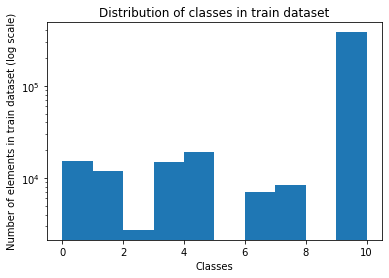

In [33]:
plt.hist(y_train)
plt.title('Distribution of classes in train dataset')
plt.yscale('log')
plt.ylabel('Number of elements in train dataset (log scale)')
plt.xlabel('Classes')
plt.show()

In [34]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 3.390478714008126,
 1: 4.267000138946783,
 2: 18.7413645795191,
 3: 3.4742510634446555,
 4: 2.650029339684512,
 6: 7.3065905305734,
 7: 6.067172435593489,
 9: 1.7408478169676769,
 10: 0.14543257163748505}

## Обучение модели

In [35]:
params = {'loss_function':'MultiClass',
          'eval_metric':'TotalF1:average=Macro',
          'custom_metric':'Recall',
          'class_weights': class_weights,
          'verbose': 200,
          'iterations': 10000,
          'depth': 3
         }
model = CatBoostClassifier(**params)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050652
0:	learn: 0.3275724	test: 0.3280577	best: 0.3280577 (0)	total: 385ms	remaining: 1h 4m 5s
200:	learn: 0.9371113	test: 0.9345547	best: 0.9350958 (194)	total: 47.7s	remaining: 38m 47s
400:	learn: 0.9547744	test: 0.9532518	best: 0.9532693 (399)	total: 1m 33s	remaining: 37m 16s
600:	learn: 0.9639782	test: 0.9641153	best: 0.9641680 (599)	total: 2m 19s	remaining: 36m 25s
800:	learn: 0.9665119	test: 0.9665219	best: 0.9665341 (794)	total: 3m 8s	remaining: 36m
1000:	learn: 0.9690993	test: 0.9687838	best: 0.9687838 (1000)	total: 3m 57s	remaining: 35m 37s
1200:	learn: 0.9700543	test: 0.9696995	best: 0.9697417 (1178)	total: 4m 47s	remaining: 35m 4s
1400:	learn: 0.9712694	test: 0.9710837	best: 0.9711199 (1399)	total: 5m 37s	remaining: 34m 30s
1600:	learn: 0.9725904	test: 0.9723218	best: 0.9723603 (1577)	total: 6m 29s	remaining: 34m 4s
1800:	learn: 0.9737916	test: 0.9728587	best: 0.9728931 (1793)	total: 7m 22s	remaining: 33m 35s
2000:	learn: 0.9744573	test: 0.9733633	bes

## Важность признаков

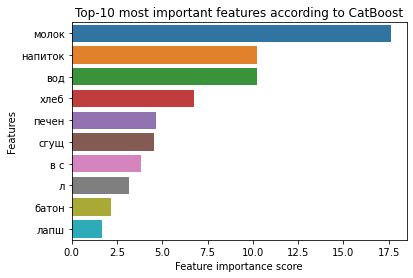

In [36]:
feature_importance = model.get_feature_importance()
feature_ranks = feature_importance.argsort()[::-1]
sns.barplot(y=X.columns[feature_ranks[:10]],x=feature_importance[feature_ranks[:10]])
plt.title('Top-10 most important features according to CatBoost')
plt.ylabel('Features')
plt.xlabel('Feature importance score')
plt.show()

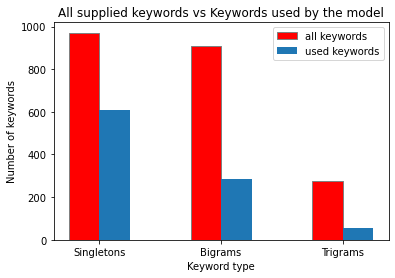

In [77]:
barWidth = 0.25
important_keywords = X.columns[feature_importance > 0.0001]
all_keywords = [len(name_words), len(bigram_words), len(trigram_words)]
significant_keywords = [len(set(important_keywords).intersection(set(name_words))), 
                        len(set(important_keywords).intersection(set(bigram_words))),  
                        len(set(important_keywords).intersection(set(trigram_words)))]
br1 = np.arange(len(all_keywords))
br2 = [x + barWidth for x in br1]
plt.bar(br1, all_keywords, color ='r', width = barWidth,
        edgecolor ='grey', label ='all keywords')
plt.bar(br2, significant_keywords, width = barWidth, label ='used keywords')
plt.xlabel('Keyword type')
plt.ylabel('Number of keywords')
plt.xticks([r + barWidth/2 for r in range(len(all_keywords))],
        ['Singletons', 'Bigrams', 'Trigrams'])
plt.legend()
plt.title('All supplied keywords vs Keywords used by the model')
plt.show()

## Промежуточное сохраниние результатов

`model.json` -- обученная модель

`column_names.csv` -- названия всех использованных признаков

`important_keywords.csv` -- названия признаков, от которых существенно зависят предсказания моделей

In [37]:
model.save_model(
    "model.json",
    format="json",
    # pool=pool  # this parameter is required only for models with categorical features.
)

In [38]:
pd.Series(important_keywords).to_csv('./important_keywords.csv', index=False)

In [39]:
pd.Series(X.columns).to_csv('./column_names.csv', index=False)

## Оценка точности

In [40]:
pred = model.predict(X_test)

In [41]:
from sklearn.metrics import recall_score

score = recall_score(y_test, pred, average='macro')
print("Recall score:", score)

Recall score: 0.9787484983182237


## Предсказание на тестовых данных

In [42]:
df_test = pd.read_csv("test_dataset_test.csv", index_col='id').dropna()
df_test.head(3)

,name
id,
10529,"КАРАМЕЛЬ ""ЛАКОМКА-СУПЕРМОЛОЧНАЯ"" ВЕС (РОТ ФРОНТ)"
10530,"2: 3637233 РАЭ Масло ТРАДИЦ.слив.82,5% 1"
10531,960012-LG NS Бинт эластичный Classic лаймовый...


In [43]:
key_words = pd.read_csv('column_names.csv').iloc[:, 0]
name_words = list(filter(lambda x: '_' not in x and len(x.split()) == 1, key_words))
bigram_words = list(filter(lambda x: '_' not in x and len(x.split()) == 2, key_words))
trigram_words = list(filter(lambda x: '_' not in x and len(x.split()) == 3, key_words))

In [44]:
df_test['total_len'] = df_test['name'].fillna(' ').progress_apply(len)
df_test['name'] = df_test['name'].fillna('').progress_apply(lambda x: ' '.join(filter(lambda x: len(x) > 0, map(stemmer.stem, 
                                                                                    re.split(r'[ ,"\-.()0-9//%:\*]', 
                                                                                             x)))))
df_test['sign_len'] = df_test['name'].fillna('').progress_apply(len)
df_test['sign_frac'] = df_test['sign_len']/df_test['total_len']
df_test['count_'] = df_test['name'].fillna('').progress_apply(lambda x: len(x.split()))
df_test['avg_len'] = df_test['total_len']/df_test['count_']

  0%|          | 0/282227 [00:00<?, ?it/s]

  0%|          | 0/282227 [00:00<?, ?it/s]

  0%|          | 0/282227 [00:00<?, ?it/s]

  0%|          | 0/282227 [00:00<?, ?it/s]

In [45]:
df_test = pd.concat([df_test] + [pd.DataFrame({word: df_test["name"].map(lambda x: count_instances(x, word))})
                      for word in tqdm(name_words)], axis=1)

  0%|          | 0/971 [00:00<?, ?it/s]

In [46]:
word_lengths = pd.Series({word: len(word) for word in name_words})
df_test['word_count'] = df_test[[word for word in name_words]].sum(axis=1)
df_test['word_frac'] = df_test['word_count']/(df_test['count_'] +0.0001)
df_test['word_total_len'] = (df_test[[word for word in name_words]]*word_lengths).sum(axis=1)
df_test['word_avg_len'] = df_test['word_total_len']/(df_test['word_count'] +0.0001)

In [47]:
df_test = pd.concat([df_test] + [pd.DataFrame({word: df_test["name"].map(lambda x: count_instances(x, word))})
                      for word in tqdm(bigram_words)], axis=1)

  0%|          | 0/910 [00:00<?, ?it/s]

In [48]:
bigram_lengths = pd.Series({word: len(word) for word in bigram_words})
df_test['bigram_count'] = df_test[[word for word in bigram_words]].sum(axis=1)
df_test['bigram_frac'] = df_test['bigram_count']/(df_test['count_'] +0.0001)
df_test['bigram_total_len'] = (df_test[[word for word in bigram_words]]*bigram_lengths).sum(axis=1)
df_test['bigram_avg_len'] = df_test['bigram_total_len']/(df_test['bigram_count'] +0.0001)

In [49]:
df_test = pd.concat([df_test] + [pd.DataFrame({word: df_test["name"].map(lambda x: count_instances(x, word))})
                      for word in tqdm(trigram_words)], axis=1)

  0%|          | 0/278 [00:00<?, ?it/s]

In [50]:
trigram_lengths = pd.Series({word: len(word) for word in trigram_words})
df_test['trigram_count'] = df_test[[word for word in trigram_words]].sum(axis=1)
df_test['trigram_frac'] = df_test['trigram_count']/(df_test['count_'] +0.0001)
df_test['trigram_total_len'] = (df_test[[word for word in trigram_words]]*trigram_lengths).sum(axis=1)
df_test['trigram_avg_len'] = df_test['trigram_total_len']/(df_test['trigram_count'] + 0.0001)

In [51]:
df_test['total_count'] = df_test['word_count']+df_test['bigram_count']+df_test['trigram_count']
df_test['max_count'] = df_test['word_count']-df_test['bigram_count']+df_test['trigram_count']
df_test['sign_total_len'] = df_test['word_total_len']+df_test['bigram_total_len']+df_test['trigram_total_len']
df_test['sign_avg_len'] = df_test['sign_total_len']/(df_test['total_count'] + 0.001)

In [52]:
df_test = df_test.drop(columns=['name'])

In [53]:
df_test.head(3)

,total_len,sign_len,sign_frac,count_,avg_len,компан,любан,ун,эдельвейс,д,...,ж б шт,в к мин,trigram_count,trigram_frac,trigram_total_len,trigram_avg_len,total_count,max_count,sign_total_len,sign_avg_len
id,,,,,,,,,,,,,,,,,,,,,
10529,48,40,0.833333,6,8.0,0,0,0,0,0,...,0,0,0,0.0,0,0.0,3,1,19,6.331223
10530,40,20,0.500000,4,10.0,0,0,0,0,0,...,0,0,0,0.0,0,0.0,1,1,4,3.996004
10531,52,39,0.750000,8,6.5,0,0,0,0,0,...,0,0,0,0.0,0,0.0,1,1,1,0.999001


In [54]:
submission = pd.read_csv("sample_solution.csv", index_col='id')
submission.head(3)

,groups
id,
10529,0
10530,0
10531,0


In [55]:
model = CatBoostClassifier()
model.load_model("model.json", "json")

In [56]:
submission['groups'] = model.predict(df_test)
submission.head(3)

,groups
id,
10529,10
10530,10
10531,10


In [57]:
submission['groups'].value_counts()

10    204315
9      18457
4      12283
0       9667
3       9659
1       8886
6       8595
7       8407
2       1958
Name: groups, dtype: int64

In [58]:
submission.to_csv("./submission.csv")